In [1]:
import os
import logging
from sqlalchemy import create_engine
from sqlalchemy import Table, Column, Integer, String, DateTime, Date, MetaData, ForeignKey
from sqlalchemy.sql import select, text

In [2]:
handler = logging.FileHandler('sql.log')
handler.setLevel(logging.INFO)
logging.getLogger('sqlalchemy').addHandler(handler)
engine = create_engine("sqlite:///test.db")

In [3]:
metadata = MetaData()

In [4]:
droid_ids = Table('droid_ids', metadata,
                Column('id', Integer, primary_key=True),
                 Column('parent_id', Integer),
                 Column('uri', String),
                 Column('file_path', String),
                 Column('filename', String),
                 Column('id_method', String),
                 Column('status', String),
                 Column('size', Integer),
                 Column('type', String),
                 Column('file_extension', String),
                 Column('last_modified', DateTime),
                 Column('ext_mis_warning', String),
                 Column('hash', String),
                 Column('file_format_count', Integer),
                 Column('project_name', String))

droid_formats = Table('droid_formats',metadata,
                      Column('id',Integer, primary_key=True),
                      Column('file_id', Integer, ForeignKey('droid_ids.id')),
                      Column('pronom_id', String),
                      Column('mime_type', String),
                      Column('file_format_name', String),
                      Column('file_format_version', String))

In [5]:
metadata.create_all(engine)
conn = engine.connect()

In [6]:
import csv
import datetime

files = []
outputfile = 'testingout.csv'
root_folder = 'input'
for filename in os.listdir(root_folder):
    f = os.path.join(root_folder,filename)
    if os.path.isfile(f):
        files.append(f)

columns = ['id','parent_id','uri','file_path','filename','id_method',
          'status','size','type','file_extension','last_modified',
           'ext_mis_warning','hash','file_format_count','pronom_id',
          'mime_type','file_format_name','file_format_version','project_name']

droid_headers = ["id","parent_id","uri",
                 "file_path","filename","id_method",
                 "status","size","type","file_extension",
                 "last_modified","ext_mis_warning",
                 "hash","file_format_count","pronom_id","mime_type",
                        "file_format_name","file_format_version"]

droid_headers_id = ["id","parent_id","uri",
                 "file_path","filename","id_method",
                 "status","size","type","file_extension",
                 "last_modified","ext_mis_warning",
                 "hash","file_format_count"]

droid_headers_format = ["id","file_id","pronom_id","mime_type",
                        "file_format_name","file_format_version"]

droid_int_headers = ["id", "parent_id", "size"]
droid_date_headers = ["last_modified"]

In [7]:
#
def map_droid_dict_id_values(row_dict):
    new_row_dict_id = {}
    for k in row_dict.keys():
        if k in droid_int_headers:
            new_row_dict_id[k] = int(row_dict[k]) if row_dict[k] else 0
        elif k in droid_date_headers:
            new_row_dict_id[k] = datetime.datetime.strptime(row_dict[k], '%Y-%m-%dT%H:%M:%S') if row_dict[k] else datetime.datetime.today()
        elif k in droid_headers_id:
            new_row_dict_id[k] = row_dict[k]
    return new_row_dict_id

def map_droid_dict_format_values(temp_id,row_dict):
    new_row_dict_format = {}
    for k in droid_headers_format:
        if k == 'id':
            new_row_dict_format[k] = temp_id
        elif k == 'file_id':
            new_row_dict_format[k] = int(row_dict['id']) if row_dict['id'] else 0
        elif k in droid_headers_format:
            new_row_dict_format[k] = row_dict[k]
    return new_row_dict_format


def insert_dict_list(csv_files, output_ids, output_formats):
    total_files = len(csv_files)
    progress_step = (int)(total_files / 10)
    progress = 0
    project_name = ''
    id_id = 0
    format_id = 0
    previous_count = 0
    current_count = 0
    print(f'[',end="")
    for file in csv_files:
        if progress == progress_step:
            print(f'-',end="")
            progress = 0
        progress += 1
        with open(file, 'r',encoding='utf-8') as f:
            first_row = True
            dict_reader = csv.DictReader(f, fieldnames=droid_headers)
            for row in dict_reader:
                if not first_row:
                    new_row_id = map_droid_dict_id_values(row)
                    new_row_format = map_droid_dict_format_values(format_id, row)
                    if new_row_id['id'] == 2:
                        previous_count += current_count
                        
                        if '/' in new_row_id['file_path']:
                            project_name = new_row_id['file_path'].split("/")
                        else:
                            project_name = new_row_id['file_path'].split("\\")
                            
                        project_name = project_name[-1]
                        new_row_id['parent_id'] = new_row_id['parent_id'] + previous_count
           
                    current_count += 1
                    new_row_id['id'] += previous_count
                    new_row_format['file_id'] = new_row_id['id']
                    new_row_id['project_name'] = project_name
                    output_ids.append(new_row_id)
                    output_formats.append(new_row_format)
                    format_id += 1

                    if None in row:
                        extra = row[None]
                        for x in range(0, len(extra), 4):
                            temp_row = {'id': format_id,'file_id':new_row_id['id'],'pronom_id':extra[x],
                                        'mime_type':extra[x + 1],'file_format_name':extra[x + 2],
                                        'file_format_version':extra[x + 3]}
                            output_formats.append(temp_row)
                            format_id += 1

                first_row = False
    print(f'] Complete')

#     count = len(output_ids)
#     with open(outputfile, 'w', newline='', encoding='utf-8') as f:
#         writer = csv.DictWriter(f, fieldnames=columns)
#         writer.writeheader()
#         for i in range(count):
# #             writer.writerow(output_ids[i])
#             try:
#                 writer.writerow(output_ids[i])
#             except:
#                 print(output_ids[i])
#                 break

In [ ]:
ins_ids = droid_ids.insert()
ins_formats = droid_formats.insert()

insert_list_ids = []
insert_list_formats = []

insert_dict_list(files, insert_list_ids, insert_list_formats)

max_size = len(insert_list_ids)

[-------

In [ ]:
insert_list_ids[10000]

In [ ]:
insert_list_formats[10091]

In [ ]:
print(max_size)

In [ ]:
start = 0
step1 = (int)(max_size / 10)
for i in range(1,max_size+1,step1):
    stop = i
    if stop > max_size:
        stop = max_size
    try:
        conn.execute(ins_ids, insert_list_ids[start:stop])
        start = stop
    except Exception as e:
        print(e)
        break
try:
    conn.execute(ins_ids, insert_list_ids[start:max_size])
except Exception as e:
    print(e)    

In [ ]:
id = 0;
max_size = len(insert_list_formats)
print(max_size)

In [ ]:
start = 0
step1 = (int)(max_size / 10)
for i in range(1,max_size+1,step1):
    stop = i
    if stop > max_size:
        stop = max_size
    try:
        conn.execute(ins_formats, insert_list_formats[start:stop])
        start = stop
    except Exception as e:
        print(e)
        break
        
try:
    conn.execute(ins_formats, insert_list_formats[start:max_size])
except Exception as e:
    print(e)  

In [15]:
s = text('select count(*) from droid_ids where file_extension = "png" and hash = ""')
conn.execute(s).fetchall()

[(0,)]

In [16]:
s = text('select count(distinct file_format_name) from droid_formats')
conn.execute(s).fetchall()

[(420,)]

In [18]:
s = text('select distinct file_format_name from droid_formats limit 20')
conn.execute(s).fetchall()

2021-06-29 11:38:22,236 INFO sqlalchemy.engine.Engine select distinct file_format_name from droid_formats limit 20
2021-06-29 11:38:22,237 INFO sqlalchemy.engine.Engine [generated in 0.00066s] ()


[('',),
 ('Acrobat PDF 1.4 - Portable Document Format',),
 ('Adobe Photoshop',),
 ('JPEG File Interchange Format',),
 ('Microsoft Excel 97 Workbook (xls)',),
 ('Microsoft Project',),
 ('Acrobat PDF 1.2 - Portable Document Format',),
 ('Microsoft Word Document',),
 ('Microsoft Publisher',),
 ('Python Script File',),
 ('Plain Text File',),
 ('Portable Network Graphics',),
 ('Windows Portable Executable',),
 ('XML Schema Definition',),
 ('Extensible Markup Language',),
 ('Tagged Image File Format',),
 ('Waveform Audio (PCMWAVEFORMAT)',),
 ('MPEG 1/2 Audio Layer 3',),
 ('MIDI Audio',),
 ('Wordperfect Secondary File',)]

In [19]:
s = text('select file_format_name, count() from droid_formats group by file_format_name order by count() desc limit 20')
conn.execute(s).fetchall()

2021-06-29 11:38:22,252 INFO sqlalchemy.engine.Engine select file_format_name, count() from droid_formats group by file_format_name order by count() desc limit 20
2021-06-29 11:38:22,253 INFO sqlalchemy.engine.Engine [generated in 0.00057s] ()


[('', 1459340),
 ('Portable Network Graphics', 428643),
 ('JPEG File Interchange Format', 245572),
 ('Tagged Image File Format', 107901),
 ('Maya IFF Image File', 67836),
 ('Exchangeable Image File Format (Compressed)', 61378),
 ('Hypertext Markup Language', 59186),
 ('Java Compiled Object Code', 49223),
 ('AppleDouble Resource Fork', 44200),
 ('Binary File', 43865),
 ('Python Script File', 43803),
 ('OpenEXR', 43397),
 ('Extensible Markup Language', 39662),
 ('Windows Portable Executable', 37404),
 ('MPEG 1/2 Audio Layer 3', 29594),
 ('Graphics Interchange Format', 29507),
 ('Python Compiled File', 27170),
 ('JavaScript file', 21918),
 ('Adobe Photoshop', 21169),
 ('Java language source code file', 21080)]

In [20]:
s = text('select file_format_name, file_extension, count() from droid_formats join droid_ids on droid_formats.file_id = droid_ids.id where file_format_name = "" and type != "Folder" group by file_extension order by count() desc limit 20') 
print(s)

select file_format_name, file_extension, count() from droid_formats join droid_ids on droid_formats.file_id = droid_ids.id where file_format_name = "" and type != "Folder" group by file_extension order by count() desc limit 20


In [21]:
conn.execute(s).fetchall()

2021-06-29 11:38:24,119 INFO sqlalchemy.engine.Engine select file_format_name, file_extension, count() from droid_formats join droid_ids on droid_formats.file_id = droid_ids.id where file_format_name = "" and type != "Folder" group by file_extension order by count() desc limit 20
2021-06-29 11:38:24,120 INFO sqlalchemy.engine.Engine [generated in 0.00084s] ()


[('', '', 381066),
 ('', 'meta', 124738),
 ('', 'h', 66092),
 ('', 'svn-base', 43077),
 ('', 'cs', 34937),
 ('', 'mat', 31775),
 ('', 'cpp', 28891),
 ('', 'pdc', 26986),
 ('', 'svn-work', 20831),
 ('', 'as', 19478),
 ('', 'xnb', 18865),
 ('', 'c', 14954),
 ('', 'prefab', 12948),
 ('', 'hpp', 12761),
 ('', 'obj', 9995),
 ('', 'shader', 9535),
 ('', 'png', 7981),
 ('', 'egg', 7376),
 ('', 'asset', 6887),
 ('', 'i', 6804)]

In [22]:
s = text('select file_path, filename from droid_ids join droid_formats on droid_formats.file_id = droid_ids.id where type != "Folder" and file_extension = "" and file_format_name = "" limit 10')
conn.execute(s).fetchall()

2021-06-29 11:38:27,428 INFO sqlalchemy.engine.Engine select file_path, filename from droid_ids join droid_formats on droid_formats.file_id = droid_ids.id where type != "Folder" and file_extension = "" and file_format_name = "" limit 10
2021-06-29 11:38:27,429 INFO sqlalchemy.engine.Engine [generated in 0.00055s] ()


[('/home/eric/OneDrive/etc_data_2021/randon_01/etc/projects/2006_semester_1/wfk/Miscellaneous/Software/merl package/apps/scribble/makefile', 'makefile'),
 ('/home/eric/OneDrive/etc_data_2021/randon_01/etc/projects/2006_semester_1/wfk/Miscellaneous/Software/merl package/utils/jdt/java/doc/package-list', 'package-list'),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2006_semester_3/Granny/Animation/Shots/Archive/09/09_Shot-clothSim', '09_Shot-clothSim'),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2006_semester_3/Granny/Output/Compositing/scripts/shot01', 'shot01'),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2006_semester_3/Granny/Output/Compositing/scripts/shot43b', 'shot43b'),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2006_semester_3/Granny/Output/Compositing/scripts/shot43~', 'shot43~'),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2006_semester_3/Granny/Output/Compositing/scripts/shot44~', 'shot44~'),
 ('

In [23]:
s = text('select file_format_name, count() from droid_formats group by file_format_name order by count() desc limit 20')
conn.execute(s).fetchall()

2021-06-29 11:38:27,476 INFO sqlalchemy.engine.Engine select file_format_name, count() from droid_formats group by file_format_name order by count() desc limit 20
2021-06-29 11:38:27,477 INFO sqlalchemy.engine.Engine [cached since 5.224s ago] ()


[('', 1459340),
 ('Portable Network Graphics', 428643),
 ('JPEG File Interchange Format', 245572),
 ('Tagged Image File Format', 107901),
 ('Maya IFF Image File', 67836),
 ('Exchangeable Image File Format (Compressed)', 61378),
 ('Hypertext Markup Language', 59186),
 ('Java Compiled Object Code', 49223),
 ('AppleDouble Resource Fork', 44200),
 ('Binary File', 43865),
 ('Python Script File', 43803),
 ('OpenEXR', 43397),
 ('Extensible Markup Language', 39662),
 ('Windows Portable Executable', 37404),
 ('MPEG 1/2 Audio Layer 3', 29594),
 ('Graphics Interchange Format', 29507),
 ('Python Compiled File', 27170),
 ('JavaScript file', 21918),
 ('Adobe Photoshop', 21169),
 ('Java language source code file', 21080)]

In [24]:
s = text('select droid_ids.id, filename, file_extension, project_name, size from droid_ids join droid_formats on droid_ids.id = droid_formats.file_id group by file_id having count(file_id) > 1 order by count(file_id) and droid_ids.id limit 20') 
print(s)

select droid_ids.id, filename, file_extension, project_name, size from droid_ids join droid_formats on droid_ids.id = droid_formats.file_id group by file_id having count(file_id) > 1 order by count(file_id) and droid_ids.id limit 20


In [25]:
conn.execute(s).fetchall()

2021-06-29 11:38:29,299 INFO sqlalchemy.engine.Engine select droid_ids.id, filename, file_extension, project_name, size from droid_ids join droid_formats on droid_ids.id = droid_formats.file_id group by file_id having count(file_id) > 1 order by count(file_id) and droid_ids.id limit 20
2021-06-29 11:38:29,300 INFO sqlalchemy.engine.Engine [generated in 0.00096s] ()


[(896, 'Programming Schema Overview.doc', 'doc', 'wfk', 0),
 (3238, 'Art & Visual Design Overview.doc', 'doc', 'wfk', 0),
 (7691, 'Sound & Music Overview.doc', 'doc', 'wfk', 1122),
 (9017, 'Accounting.xls', 'xls', 'CERT-Computer_Emergency_Response_Team', 0),
 (9021, 'Art & Visual Design Overview.doc', 'doc', 'CERT-Computer_Emergency_Response_Team', 0),
 (9982, 'Programming Schema Overview.doc', 'doc', 'CERT-Computer_Emergency_Response_Team', 0),
 (10815, 'Final Presentation.ppt', 'ppt', 'CERT-Computer_Emergency_Response_Team', 0),
 (10816, 'Soft Opening.ppt', 'ppt', 'CERT-Computer_Emergency_Response_Team', 0),
 (10878, 'service.lck', 'lck', 'CERT-Computer_Emergency_Response_Team', 0),
 (11152, 'Sound & Music Overview.doc', 'doc', 'CERT-Computer_Emergency_Response_Team', 0),
 (11423, 'service.lck', 'lck', 'CERT-Computer_Emergency_Response_Team', 0),
 (20809, 'Accounting.xls', 'xls', 'Granny', 0),
 (20815, 'Art & Visual Design Overview.doc', 'doc', 'Granny', 0),
 (20828, 'Programming Sch

In [26]:
s = text('select * from droid_ids where hash = "" and type != "Folder" limit 20')
conn.execute(s).fetchall()

2021-06-29 11:38:36,782 INFO sqlalchemy.engine.Engine select * from droid_ids where hash = "" and type != "Folder"
2021-06-29 11:38:36,783 INFO sqlalchemy.engine.Engine [generated in 0.00101s] ()


[]

In [ ]:
s = text('select count() from droid_ids where hash = ""')
conn.execute(s).fetchall()

In [ ]:
s = text('select count() from droid_ids where type = "Folder"')
conn.execute(s).fetchall()

In [ ]:
s = text('select count(distinct hash) from droid_ids')
conn.execute(s).fetchall()

In [ ]:
s = text('select count(id) from droid_ids where type = "File"')
conn.execute(s).fetchall()

In [ ]:
s = text('select hash, count() from droid_formats join droid_ids on droid_ids.id = droid_formats.file_id where type = "File" group by hash order by count() desc limit 20')
conn.execute(s).fetchall()

In [47]:
s = text('select filename, file_extension, project_name, size, file_path from droid_ids where hash = "999360eebbd725d06fa9d4f36424f077ccc8c347d567988a614e96b66e105321" group by project_name limit 20')
conn.execute(s).fetchall()

In [14]:
s = text('select file_path from droid_ids where filename = "BuildSettings.asset" limit 20')
conn.execute(s).fetchall()

2021-06-30 13:34:47,266 INFO sqlalchemy.engine.Engine select file_path from droid_ids where filename = "BuildSettings.asset" limit 20
2021-06-30 13:34:47,267 INFO sqlalchemy.engine.Engine [generated in 0.00117s] ()


[('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2009_semester_1/serious-games/Code/Additional Scripts/Library/BuildSettings.asset',),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2009_semester_1/serious-games/Code/Code in Progress/NEWScripts/camerawork/Library/BuildSettings.asset',),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2009_semester_1/serious-games/Code/Code in Progress/NEWScripts/newscripts/Library/BuildSettings.asset',),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2009_semester_1/serious-games/Code/Code in Progress/Source/dataCollect_old/Library/BuildSettings.asset',),
 ('/home/eric/OneDrive/etc_data_2021/randon_02/etc/projects/2009_semester_1/serious-games/Final Demo/Project Folder/City Demo Project Folder/Library/BuildSettings.asset',),
 ('/home/eric/OneDrive/etc_data_2021/randon_01/etc/projects/2010_semester_1/lm_motion_control/Code/Earlier Vesrions_4-25_3-03pm/Library/BuildSettings.asset',),
 ('/home/eric/OneDrive

In [7]:
import matplotlib.pyplot as plt

In [8]:
%matplotlib inline

In [9]:
s = text('select file_format_name, count() from droid_ids join droid_formats on droid_ids.id = droid_formats.file_id where type = "File" group by file_format_name order by count() desc')
file_format_name_population = conn.execute(s).fetchall()

2021-06-30 13:31:49,752 INFO sqlalchemy.engine.Engine select file_format_name, count() from droid_ids join droid_formats on droid_ids.id = droid_formats.file_id where type = "File" group by file_format_name order by count() desc
2021-06-30 13:31:49,753 INFO sqlalchemy.engine.Engine [generated in 0.00125s] ()


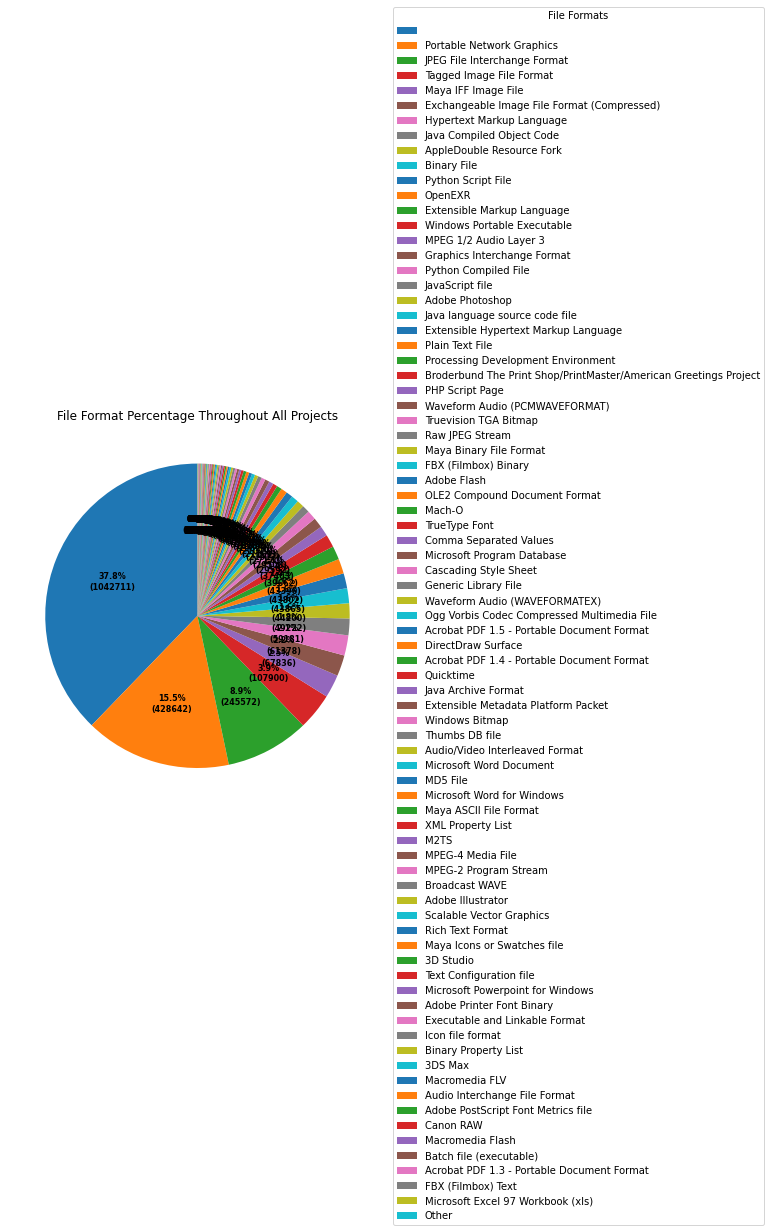

In [11]:
import numpy as np
import pandas as pd

from jupyter_datatables import init_datatables_mode

#init_datatables_mode()

file_format_names = []
file_format_count = []
file_format_names_1 = []

for elem in file_format_name_population:
    if elem[1] > 1000:
        file_format_names.append(elem[0])
        file_format_count.append(elem[1])
    else:
        file_format_names_1.append(elem[0])
        
minority_count = len(file_format_names_1)

if minority_count > 1:
    file_format_names.append('Other')
    file_format_count.append(minority_count)
    
def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots(figsize =(10, 7))
wedges, texts, autotexts = ax.pie(file_format_count, 
                                  autopct = lambda pct: func(pct, file_format_count),
                                  startangle = 90)

# Adding legend
ax.legend(wedges, file_format_names,
          title ="File Formats",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
    
plt.setp(autotexts, size = 8, weight ="bold")
ax.set_title('File Format Percentage Throughout All Projects')
    
plt.show()